Prompt-Tuning是通过调整输入提示来引导模型更准确地理解任务的微调方法。
- 模型的权重不发生变化
- 微调仅涉及对输入提示进行优化

In [99]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset

In [100]:
# 定义Prompt Tuning模块，用于动态调整输入Prompt
class PromptTuning(nn.Module):
    def __init__(self, prompt_length: int, embedding_size: int):
        super(PromptTuning, self).__init__()
        self.prompt_embedding = nn.Parameter(torch.randn(prompt_length, embedding_size))
    
    def forward(self, embedded_input):
        N = embedded_input.size(0)
        prompt_embeded = self.prompt_embedding.unsqueeze(0).expand(N, -1, -1)
        return torch.cat((prompt_embeded, embedded_input), dim=1)

In [101]:
a = torch.tensor([[1, 2, 3]])
b = torch.tensor([[4, 5, 6]])
torch.cat((a, b), dim=1), a.unsqueeze(0).shape

(tensor([[1, 2, 3, 4, 5, 6]]), torch.Size([1, 1, 3]))

In [102]:
# 加载BERT模型和分词器
tokenizer = BertTokenizer.from_pretrained('../bert-base-uncased')

In [103]:
# 数据准备函数
def prepare_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return TensorDataset(
        encodings["input_ids"],
        encodings["attention_mask"],
        torch.tensor(labels)
    )

In [104]:
# 定义示例数据
texts = [
    'The model performs well with prompt tuning.',
    'Prompt-based learning enhances performance.',
]
labels = [1, 0]
dataset = prepare_data(texts, labels, tokenizer)

dataloader = DataLoader(dataset, batch_size=2)

In [105]:
# Prompt Tuning参数
class BertWithPromptTuning(nn.Module):
    def __init__(self, prompt_length: int, bert: BertForSequenceClassification,):
        super(BertWithPromptTuning, self).__init__()
        self.bert = bert
        # ❗冻结 BERT 所有参数（Prompt-Tuning 核心）
        for param in self.bert.bert.parameters():
            param.requires_grad = False
        # classifier 允许训练
        for param in self.bert.classifier.parameters():
            param.requires_grad = True
        self.prompt_length = prompt_length
        self.prompt_tuning = PromptTuning(prompt_length, self.bert.config.hidden_size)

    def forward(self, input_ids, attention_mask):
        batch_size, seq_len = input_ids.shape

        # 1. 原始 token embedding（已包含 token + position + segment）
        token_embeddings = self.bert.bert.embeddings(input_ids)

        # 2. 拼接 Prompt
        inputs_embeds = self.prompt_tuning(token_embeddings)

        # 3. 扩展 attention mask
        prompt_mask = torch.ones(
            batch_size,
            self.prompt_length,
            device=attention_mask.device,
            dtype=attention_mask.dtype
        )
        extended_attention_mask = torch.cat(
            [prompt_mask, attention_mask], dim=1
        )

        # 4. 显式 position ids（Prompt + 原序列）
        position_ids = torch.arange(
            0,
            self.prompt_length + seq_len,
            device=input_ids.device
        ).unsqueeze(0).expand(batch_size, -1)

        # 5. Forward
        outputs = self.bert(
            inputs_embeds=inputs_embeds,
            attention_mask=extended_attention_mask,
            position_ids=position_ids
        )

        return outputs.logits

In [ ]:
# 实例化模型与训练组件
bert = BertForSequenceClassification.from_pretrained('../bert-base-uncased', num_labels=2)
prompt_tuned_model = BertWithPromptTuning(prompt_length=20, bert=bert)
# Optimizer
optimizer = optim.Adam(
    [
        {"params": prompt_tuned_model.prompt_tuning.parameters(), "lr": 1e-3},
        {"params": prompt_tuned_model.bert.classifier.parameters(), "lr": 1e-4},
    ]
)
criterion = nn.CrossEntropyLoss()

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 477.09it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: ../bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those

In [107]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
prompt_tuned_model.to(device)

BertWithPromptTuning(
  (bert): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features

In [ ]:
def train_one_epoch(dataloader, model, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0

    for batch in dataloader:
        input_ids, attention_mask, labels = [
            b.to(device) for b in batch
        ]

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

In [109]:
loss_history = []
for epoch in range(30):
    avg_loss, accuracy = train_one_epoch(dataloader, prompt_tuned_model, criterion, optimizer)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1, Loss: 0.8135, Accuracy: 0.0000
Epoch 2, Loss: 0.6818, Accuracy: 0.5000
Epoch 3, Loss: 0.7736, Accuracy: 0.5000
Epoch 4, Loss: 0.7635, Accuracy: 0.5000
Epoch 5, Loss: 0.6955, Accuracy: 0.5000
Epoch 6, Loss: 0.5802, Accuracy: 1.0000
Epoch 7, Loss: 0.6914, Accuracy: 0.5000
Epoch 8, Loss: 0.7132, Accuracy: 0.0000
Epoch 9, Loss: 0.6502, Accuracy: 0.5000
Epoch 10, Loss: 0.7247, Accuracy: 0.5000
Epoch 11, Loss: 0.5832, Accuracy: 1.0000
Epoch 12, Loss: 0.7093, Accuracy: 0.5000
Epoch 13, Loss: 0.6990, Accuracy: 0.5000
Epoch 14, Loss: 0.6674, Accuracy: 1.0000
Epoch 15, Loss: 0.6891, Accuracy: 0.5000
Epoch 16, Loss: 0.6735, Accuracy: 0.5000
Epoch 17, Loss: 0.7088, Accuracy: 0.5000
Epoch 18, Loss: 0.6358, Accuracy: 1.0000
Epoch 19, Loss: 0.7384, Accuracy: 0.5000
Epoch 20, Loss: 0.8115, Accuracy: 0.0000
Epoch 21, Loss: 0.7646, Accuracy: 0.5000
Epoch 22, Loss: 0.6850, Accuracy: 0.5000
Epoch 23, Loss: 0.7206, Accuracy: 0.0000
Epoch 24, Loss: 0.6951, Accuracy: 0.5000
Epoch 25, Loss: 0.6709, A

绘制训练损失曲线... [0.8134808540344238, 0.6818036437034607, 0.7736279964447021, 0.7634527683258057, 0.695496678352356, 0.5801815986633301, 0.69135582447052, 0.7132419347763062, 0.6501947641372681, 0.7246866226196289, 0.5832444429397583, 0.7093086242675781, 0.6989747285842896, 0.6673978567123413, 0.6891239881515503, 0.6735060214996338, 0.7087959051132202, 0.6357828378677368, 0.7384364604949951, 0.8115437626838684, 0.7646313309669495, 0.6850035786628723, 0.72055584192276, 0.6950904130935669, 0.6708760261535645, 0.6212272644042969, 0.6295175552368164, 0.5842751264572144, 0.6075387597084045, 0.6067799925804138]


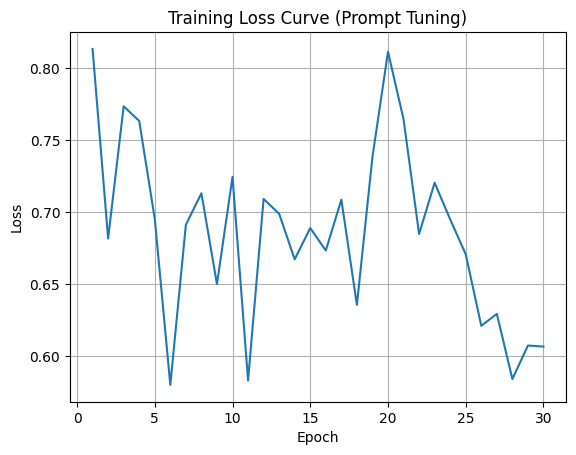

In [110]:
def plot_loss_curve(loss_history):
    import matplotlib.pyplot as plt

    print("绘制训练损失曲线...", loss_history)
    plt.figure()
    plt.plot(range(1, len(loss_history) + 1), loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve (Prompt Tuning)")
    plt.grid(True)
    plt.show()


plot_loss_curve(loss_history)